In [16]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

import random
import numpy as np
from scipy import stats

import seaborn as sns # not necessary but I like seaborn
sns.set_style('whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})

import matplotlib
import matplotlib.pyplot as plt

# plot settings
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'regular',
        'size'   : 13}
figure = {'figsize' : (10,4)}

matplotlib.rc('font', **font)
matplotlib.rc('figure', **figure)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%%time
# magic that tells you how long the cell takes to run

num_rolls = 100000 # how many simulated die rolls?

# define the function to simulate die rolls
def rollDie(number):
    roll = []
    for i in range(number):
        # note this appends the result at the end of the list every iteration
        roll = np.append(roll, random.randint(1,6))
    return roll

simulated_rolls = rollDie(num_rolls)


CPU times: user 2.04 s, sys: 94 ms, total: 2.14 s
Wall time: 2.17 s


### ~2.5 seconds to simulate 100,000 die rolls is a long time!

In [18]:
%%time

# note this version creates a numpy vector of zeros first, and rather than appending a number at the end of a list
# such as was done above, it rewrites the zeros with the result as it moves through the loop.

# this is called initializing your data, and can speed things up
# the reason this is faster is because when you append, as we did above, numpy has to grow the array each loop

num_rolls = 100000

def rollDie(number):
    roll = np.zeros((number, 1)) # initialize your vector
    for i in range(number):
        roll[i] = random.randint(1,6)
    return roll

simulated_rolls = rollDie(num_rolls)


CPU times: user 126 ms, sys: 1.75 ms, total: 127 ms
Wall time: 128 ms


### ~0.15 seconds to simulate 100,000 die rolls; much better!
### This is a 15-20x speedup!



In [19]:
%%time

## now let's get rid of the for loop, and take advantage of Python list comprehension

num_rolls = 100000

simulated_rolls = [random.randint(1,6) for i in range(num_rolls)] 


CPU times: user 95.6 ms, sys: 1.77 ms, total: 97.4 ms
Wall time: 97.2 ms


### ~0.1 seconds to simulate 100,000 die rolls!

### The moral is to always <a href = "https://en.wikipedia.org/wiki/Profiling_(computer_programming)">profile</a> your code!

### Now let's simulate 1,000,000 die rolls of a fair die using the faster function.
### Also plot the histogram of the results

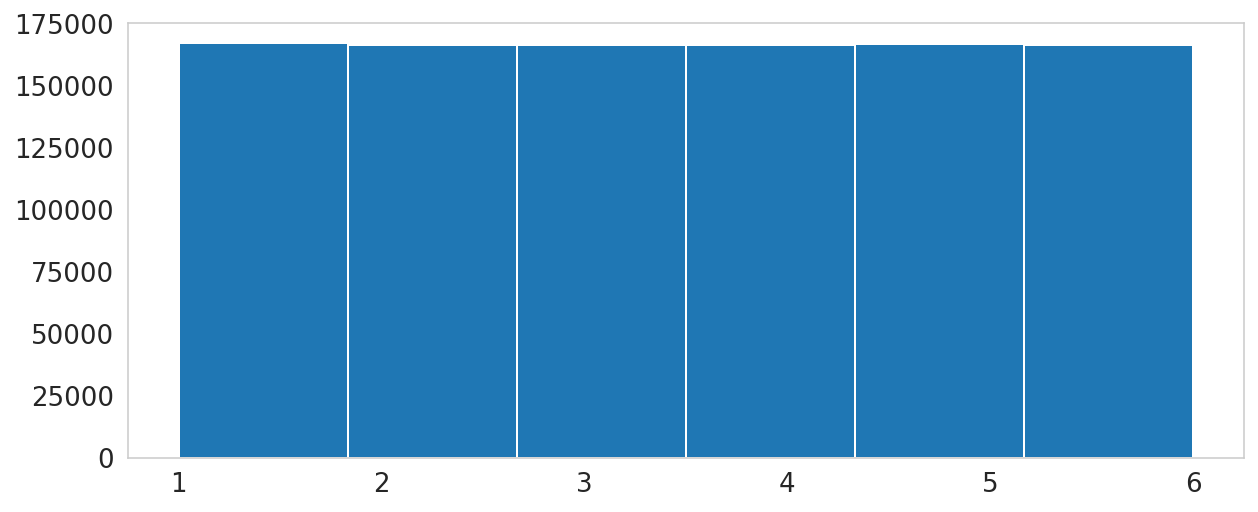

In [20]:
num_rolls = 1000000

simulated_rolls = [random.randint(1,6) for i in range(num_rolls)] 

# np.unique finds the unique values are in our data (1, 2, 3, 4, 5, 6)
# and np.size asks how many there are (6)
# we then use that to define the number of bins we want in our histogram
number_of_bins = np.size(np.unique(simulated_rolls))

plt.hist(simulated_rolls, number_of_bins)
plt.show()


### Looks decently uniform!
### So let's look at the magic that is the Central Limit Theorem.
### First, we break our data vector of die roll results, simulated_rolls, into chunks of 10 rolls each.
### Then we average each of those 10 rolls and store the result.

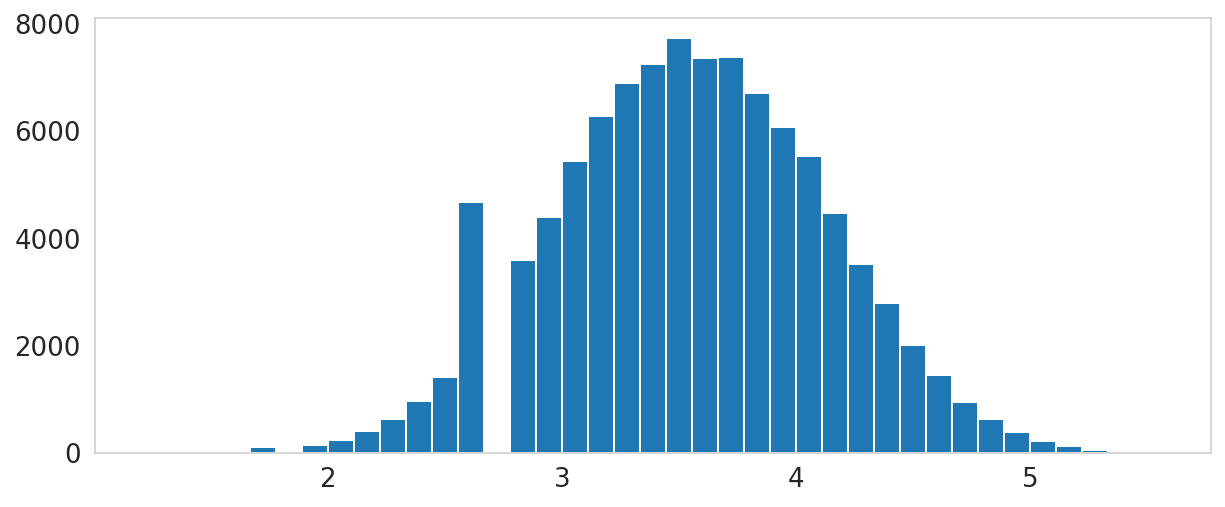

In [21]:
chuck_size = 10 # each chunk has this many rolls
samples = num_rolls//chuck_size # instead of <num_rolls> elements, we now have num_rolls/10
                                # so instead of 1,000,000 we have 100,000
roll_avg = np.zeros((samples, 1)) # initialize your vector

for i in range(samples):
    # for each loop we need to average from 0:9, 10:19, 20:29, and so on
    # this gives us a low range and a high range to average across
    # the low range (0,10,20,etc) is just i*10
    # the high range is that, plus 9
    low_range = i*10
    high_range = low_range+9
    roll_avg[i] = np.mean(simulated_rolls[low_range:high_range]) # average the chunks

# plot the histogram!
plt.hist(roll_avg, np.size(np.unique(roll_avg)))
plt.show()

In [22]:
np.mean((1,2,3,4,5,6)), np.mean(roll_avg)

(3.5, 3.4993111111111106)

### Great! Just like the CLT says, averages of samples will result in normally distributed averages.
### Unsurprusingly, the mean appears to be ~3.5, which is the mean of (1,2,3,4,5,6)

### We're going to show how we can leverage the CLT to run statistical analyses that assume normality on data that are otherwise non-normal (such as die roll probabilities).
### Note that although we're doing die rolls here, these could just as easily be star-ratings for Yelp, Uber, etc. or thumbs up/down for songs on Padora or Netflix shows.

In [23]:
# now, let's create a second set of fake die rolls
simulated_biased_rolls = rollDie(num_rolls)

# we're going to replace approximately 0.5% of each non-six result with a 6 to simulated a biased die
percent_bias = 0.005
replace_size = np.around((num_rolls/number_of_bins)*percent_bias)
replace_size = replace_size.astype(int)

# loop from 1 to 5
for i in range((number_of_bins-1)):
    idx = np.where(simulated_biased_rolls==(i+1)) # find each instance of i+1 as the die result
    replace_idx = np.random.choice(idx[0], size=replace_size, replace=True)
    simulated_biased_rolls[replace_idx] = 6

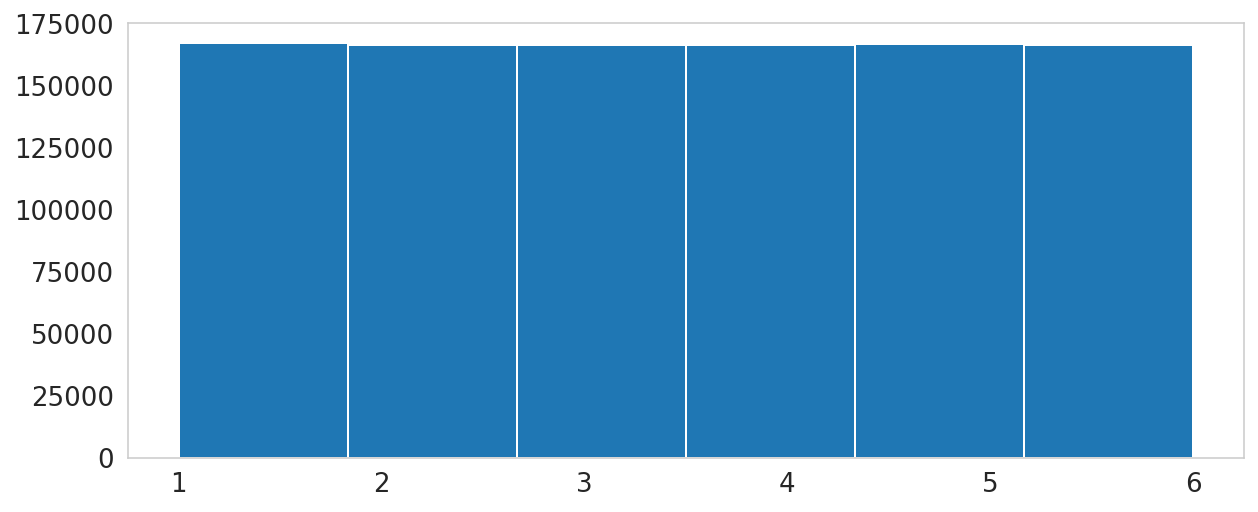

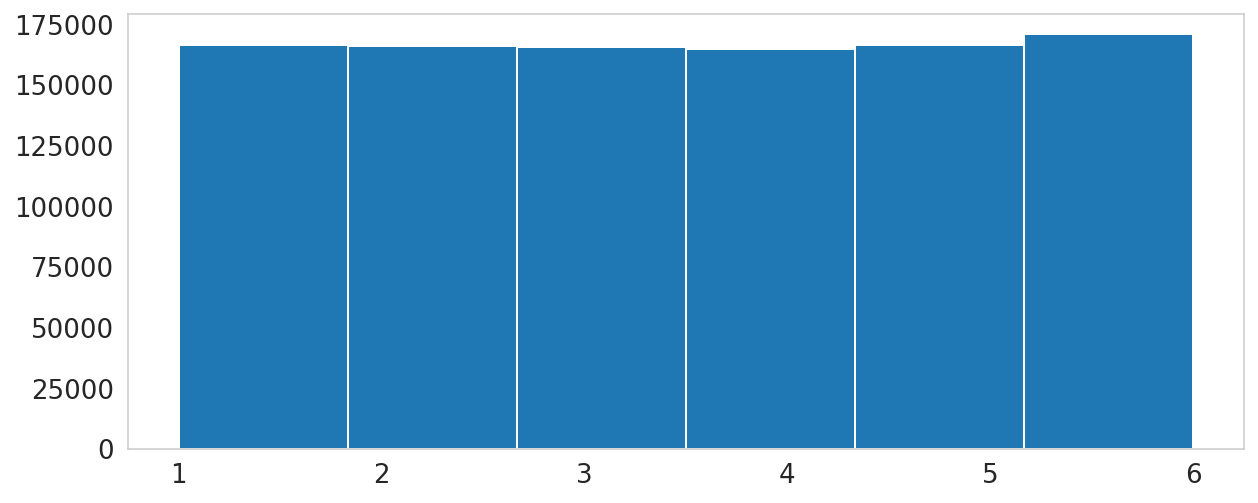

In [24]:
plt.hist(simulated_rolls, 6)
plt.show()

plt.hist(simulated_biased_rolls, 6)
plt.show()

### Okay it looks like there's a <em>little</em> bump at 6, but it's not hugely obvious.
### Let's look at the histogram of the sampels from the biased rolls and see if we see anything obvious.

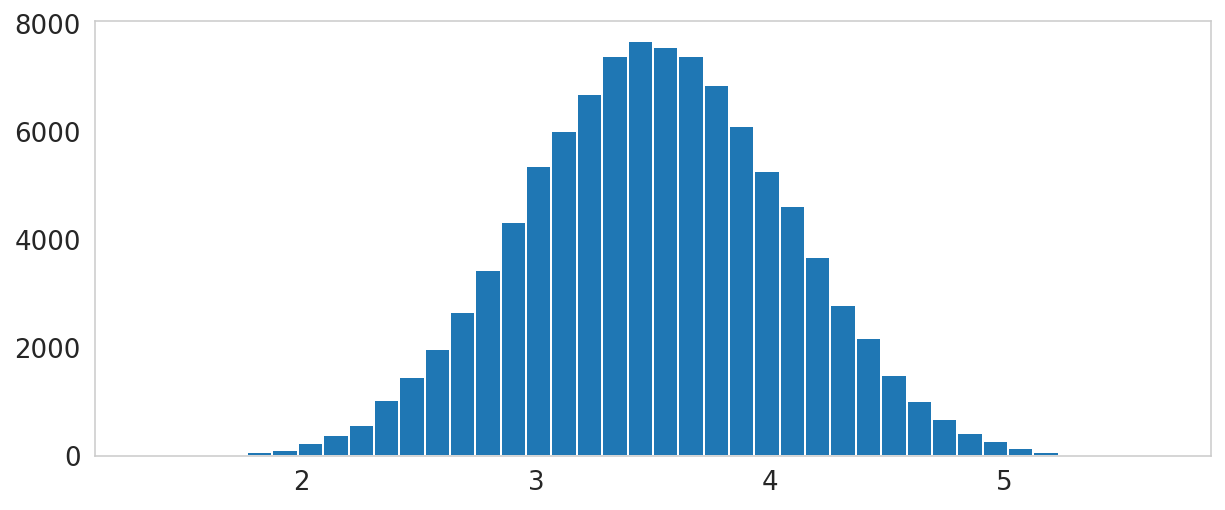

In [25]:
chuck_size = 10
samples = num_rolls//chuck_size
biased_roll_avg = np.zeros((samples, 1))

for i in range(samples):
    low_range = i*10
    high_range = low_range+9
    biased_roll_avg[i] = np.mean(simulated_biased_rolls[low_range:high_range]) # average the chunks

# plot the histogram!
plt.hist(biased_roll_avg, np.size(np.unique(biased_roll_avg)))
plt.show()

### Well, okay. Looks about the same as above...
### What's the mean of this one?

In [26]:
np.mean(biased_roll_avg)

3.5100733333333336

### Just <em>ever so slightly</em> greater than the 3.5 we'd expect.
### Is this significant though? How can we check?
### This is where the "art" of data science starts to come into play!
### How can we determine (statistically) if our die is loaded?
### We can start with the assumption that any two distributions of random samples of the means of fair die will be centered around 3.5.
### Additionally we can say that, given this, if we take a random sample of the mean of 10 die rolls from die_1, and a random sample of the mean of 10 die rolls from die_2, the difference of those means should itself be normally distributed (thanks CLT!) around 0.
### That is, any differeces should cancel out, given enough data.
### If, however, one of the die is biased—such as toward 6, in our case—that bias should force the mean of the samples to be slightly <em>greater</em> than the expected mean of 3.5, and should force the mean of the <em>differences</em> between the die to be slightly greater than 0.
### Armed with this, we can now perform a very simple independent samples t-ttest of the distribution of the differences against the assumption that the mean of the differences should be 0.

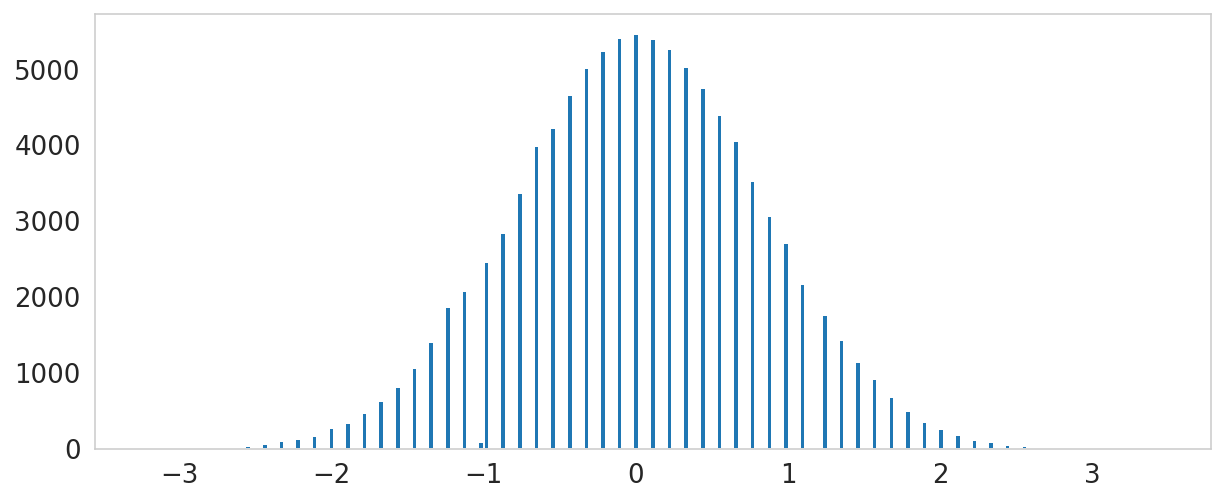

In [27]:
# get the distribution of the differences of means
chuck_size = 10
samples = num_rolls//chuck_size
roll_diff = np.zeros((samples, 1))

for i in range(samples):
    low_range = i*10
    high_range = low_range+9
    # get the mean of the differences between the die
    clean_mean = np.mean(simulated_rolls[low_range:high_range])
    biased_mean = np.mean(simulated_biased_rolls[low_range:high_range])
    roll_diff[i] = biased_mean-clean_mean

# plot the histogram!
plt.hist(roll_diff, np.size(np.unique(roll_diff)))
plt.show()

In [28]:
np.mean(roll_diff)

0.010762222222222222

### The distribution of differences between means looks normal, too!
### Also note that the mean of these differences is, indeed, slightly greater than 1.
### Now we can use a standard t-test to look at how big this difference is, and whether it's "significant".

In [29]:
t,p = stats.ttest_1samp(roll_diff, popmean=0) # compare our differences against the null, which is a mean of 0
print(['t-value: ', t[0], '; p-value: ', p[0]])

['t-value: ', 4.218623297142564, '; p-value: ', 2.4601469601869334e-05]


### Yes! It is significant.
### And just to sanity check, let's do the same thing, but this time compare our un-biased die against a second simulation of an un-biased die.

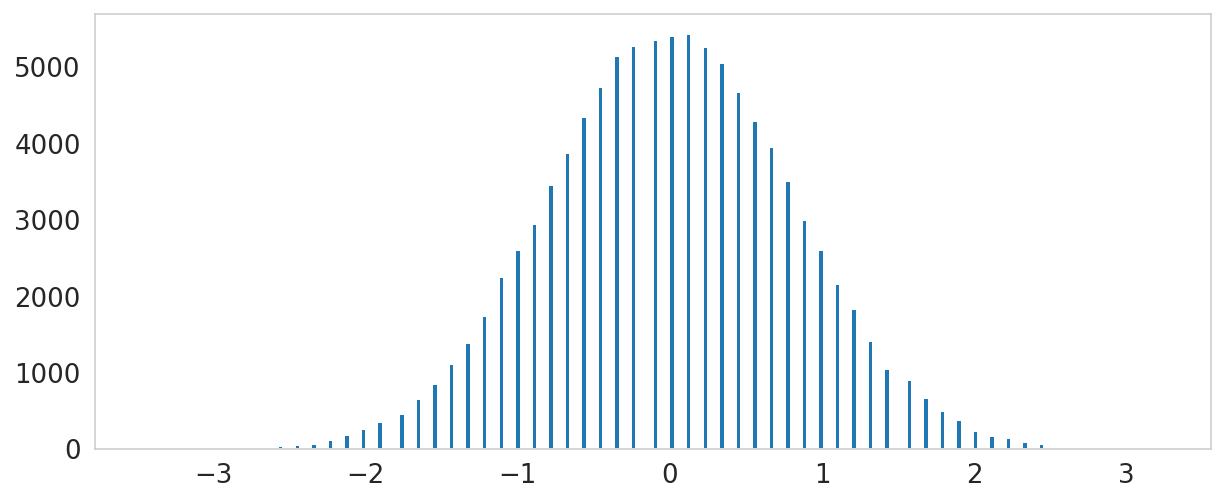

['t-value: ', 0.8078324298083677, '; p-value: ', 0.4191889751440364]


In [30]:
simulated_rolls_taketwo = rollDie(num_rolls) # simulate a second, unbiased set of rolls

chuck_size = 10
samples = num_rolls//chuck_size
unbiased_roll_diff = np.zeros((samples, 1))

for i in range(samples):
    low_range = i*10
    high_range = low_range+9
    # get the mean of the differences between the die
    clean_mean = np.mean(simulated_rolls[low_range:high_range])
    clean_mean_taketwo = np.mean(simulated_rolls_taketwo[low_range:high_range])
    unbiased_roll_diff[i] = clean_mean_taketwo-clean_mean

# plot the histogram!
plt.hist(unbiased_roll_diff, np.size(np.unique(unbiased_roll_diff)))
plt.show()
t,p = stats.ttest_1samp(unbiased_roll_diff, popmean=0) # compare our differences against the
                                                         # null, which is a mean of 0
print(['t-value: ', t[0], '; p-value: ', p[0]])

### No difference between them!

### Nice job, statistics.